# Self-Organizing Maps (SOMs) Notebook
## Data extraction for composites

**Notebook by Maria J. Molina (NCAR) and Alice DuVivier (NCAR).**

This Notebook reads in data from the CESM2-LE for a user-specified variable. It subsets the data to be just around Antarctica to create composites from.

In [1]:
# Needed imports

from minisom import MiniSom, asymptotic_decay
import xarray as xr
import cftime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from datetime import timedelta
from itertools import product

import intake
from distributed import Client
from ncar_jobqueue import NCARCluster

In [2]:
import dask
dask.__version__
# Did a conda update dask on cheyenne to get to 2021.09

'2021.09.1'

In [3]:
# start up dask

cluster = NCARCluster(memory='100 GB', walltime='1:00:00', cores=4, processes=2, resource_spec='select=1:ncpus=2:mem=100GB')
cluster.scale(40) # number of workers requested
#cluster.adapt(1,80) # min and max
client = Client(cluster)

cluster = NCARCluster(memory="100GB", walltime='8:00:00', cores=4, processes=2, resource_spec='select=1:ncpus=2:mem=100GB')
Each worker has 100GB, resource_spec is assigning this. 

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/PBS/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/PBS/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.42:40717,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/PBS/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
#dask.config.set({"array.slicing.split_large_chunks": True})

#Set dask.config.set({"array.slicing.split_large_chunks": False}) to allow the large chunk and silence the warning.

#### HERE - MAX SAID TRY THIS TOO (BELOW)
# with dask.congfig.set... (DO RIGHT BEFORE ACTUALLY READING DATA WITH DATASET DICT)
#Set dask.config.set({"array.slicing.split_large_chunks": True}) to avoid creating the large chunk in the first place.

## Section 1: Load and get correct training data

In [53]:
# set some info for the CESM2-LE data
# set: variable to test, the location of the data, which ensemble member
var_in = 'meltt_d'
 # do not want smbb data
forcing = 'cmip6'

### Load in the data

In [54]:
catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'

cat = intake.open_esm_datastore(catalog_file)

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/intake_esm/core.py:84: DtypeWarning: Columns (5,6,9) have mixed types.Specify dtype option on import or set low_memory=False.
  self._df, self.catalog_file = _fetch_catalog(self.esmcol_data, esmcol_obj, csv_kwargs)


In [55]:
subset = cat.search(variable=var_in, forcing_variant=forcing)

In [56]:
#subset
subset.df.head()

,component,stream,case,member_id,variable,start_time,end_time,time_range,long_name,units,vertical_levels,frequency,path,experiment,forcing_variant,cesm_member_id,control_branch_year,cmip_experiment_id
0,ice,cice.h1,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,meltt_d,1850-01-01,1860-01-01,18500101-18600101,top ice melt,cm/day,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
1,ice,cice.h1,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,meltt_d,1860-01-02,1870-01-01,18600102-18700101,top ice melt,cm/day,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
2,ice,cice.h1,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,meltt_d,1870-01-02,1880-01-01,18700102-18800101,top ice melt,cm/day,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
3,ice,cice.h1,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,meltt_d,1880-01-02,1890-01-01,18800102-18900101,top ice melt,cm/day,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
4,ice,cice.h1,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,meltt_d,1890-01-02,1900-01-01,18900102-19000101,top ice melt,cm/day,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1


In [57]:
# make arrays of half (25) of the CESM2-LE members 
# select every other from the large ensemble of both macro and micro starts
# note that the naming of the files (YYYY.#### e.g. 1001.001) doesn't match the member_id directly, 
# but the ensemble number (### e.g. 001) does match the member_id field r? directly. So use this to search

# set list of members from the dataset
member_ids = subset.df.member_id.unique()

# set list of members to KEEP
keep_list = ['r1i', 'r3i', 'r5i','r7i', 'r9i']


In [58]:
member_keep = [] # make a list to fill

for member in keep_list:
    for member_id in member_ids:
        if member in member_id:
            member_keep.append(member_id)

In [59]:
#check that we're keeping the right ones
member_keep

['r1i1001p1f1',
 'r1i1231p1f1',
 'r1i1251p1f1',
 'r1i1281p1f1',
 'r1i1301p1f1',
 'r3i1041p1f1',
 'r3i1231p1f1',
 'r3i1251p1f1',
 'r3i1281p1f1',
 'r3i1301p1f1',
 'r5i1081p1f1',
 'r5i1231p1f1',
 'r5i1251p1f1',
 'r5i1281p1f1',
 'r5i1301p1f1',
 'r7i1121p1f1',
 'r7i1231p1f1',
 'r7i1251p1f1',
 'r7i1281p1f1',
 'r7i1301p1f1',
 'r9i1161p1f1',
 'r9i1231p1f1',
 'r9i1251p1f1',
 'r9i1281p1f1',
 'r9i1301p1f1']

In [60]:
# now reduce subset based on just the members to keep
subset = subset.search(member_id=member_keep)

In [61]:
%%time
#actually load the data we selected into a dataset
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dsets = subset.to_dataset_dict(cdf_kwargs={'chunks': {'time':240}, 'decode_times': True})

#dsets


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 20.8 s, sys: 639 ms, total: 21.4 s
Wall time: 26.9 s


In [62]:
# print names of the dataset keys, which refer to each of the ensembles loaded
dsets.keys()

dict_keys(['ice.historical.cice.h1.cmip6.meltt_d', 'ice.ssp370.cice.h1.cmip6.meltt_d'])

In [63]:
# Look at just one dataset key to see what it looks like. 
# Note that for 1001 there is one member_id, but for 1231 there are 5 member_ids
# these refer to the individual ensemble members!

#dsets['ice.historical.cice.h1.cmip6.1001.aice_d']
#dsets['ice.historical.cice.h1.cmip6.aice_d']

In [64]:
# load in the historical and future datasets

historicals = []
futures = []

for key in sorted(dsets.keys()):
    if 'historical' in key:
        historicals.append(dsets[key])
        print(key)
    elif 'ssp370' in key:
        futures.append(dsets[key])
        print(key)

ice.historical.cice.h1.cmip6.meltt_d
ice.ssp370.cice.h1.cmip6.meltt_d


In [65]:
# Now put these into an array by member_id
historical_ds = xr.concat(historicals, dim='member_id')
future_ds = xr.concat(futures, dim='member_id')

In [66]:
# note that the historical and future xarray datasets have the same coordinates and dimensions *except* time, 
# so we need to concatenate over time
ds = xr.concat([historical_ds,future_ds],dim='time')

In [67]:
ds.time

<xarray.DataArray 'time' (time: 91615)>
array([cftime.DatetimeNoLeap(1850, 1, 2, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 1, 3, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 1, 4, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2100, 12, 30, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2101, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-02 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    long_name:  model time
    bounds:     time_bounds

In [68]:
# we need to shift time by 1 day because of weird CESM conventions
ds = ds.assign_coords(time=ds.coords["time"]-timedelta(days=1))

In [69]:
ds.time

<xarray.DataArray 'time' (time: 91615)>
array([cftime.DatetimeNoLeap(1850, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 1, 2, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 1, 3, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2100, 12, 29, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 30, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 31, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-01 00:00:00 ... 2100-12-31 00:00:00

In [70]:
ds

<xarray.Dataset>
Dimensions:      (nj: 384, ni: 320, time: 91615, member_id: 25, nc: 5, nkice: 8, nksnow: 3, nkbio: 5, nvertices: 4, d2: 2)
Coordinates:
    TLON         (nj, ni) float32 320.6 321.7 322.8 323.9 ... nan nan nan nan
    TLAT         (nj, ni) float32 -79.22 -79.22 -79.22 -79.22 ... nan nan nan
    ULON         (nj, ni) float32 321.1 322.2 323.4 324.5 ... nan nan nan nan
    ULAT         (nj, ni) float32 -78.95 -78.95 -78.95 -78.95 ... nan nan nan
  * time         (time) object 1850-01-01 00:00:00 ... 2100-12-31 00:00:00
  * member_id    (member_id) <U11 'r1i1001p1f1' 'r1i1231p1f1' ... 'r9i1301p1f1'
Dimensions without coordinates: nj, ni, nc, nkice, nksnow, nkbio, nvertices, d2
Data variables: (12/21)
    NCAT         (time, member_id, nc) float32 dask.array<chunksize=(60225, 25, 5), meta=np.ndarray>
    VGRDi        (time, member_id, nkice) float32 dask.array<chunksize=(60225, 25, 8), meta=np.ndarray>
    VGRDs        (time, member_id, nksnow) float32 dask.array<chunksize=(60225, 25, 3), meta=np.ndarray>
    VGRDb        (time, member_id, nkbio) float32 dask.array<chunksize=(60225, 25, 5), meta=np.ndarray>
    tmask        (time, member_id, nj, ni) float32 dask.array<chunksize=(60225, 25, 384, 320), meta=np.ndarray>
    tarea        (time, member_id, nj, ni) float32 dask.array<chunksize=(60225, 25, 384, 320), meta=np.ndarray>
    ...           ...
    lont_bounds  (time, member_id, nj, ni, nvertices) float32 dask.array<chunksize=(60225, 25, 384, 320, 4), meta=np.ndarray>
    latt_bounds  (time, member_id, nj, ni, nvertices) float32 dask.array<chunksize=(60225, 25, 384, 320, 4), meta=np.ndarray>
    lonu_bounds  (time, member_id, nj, ni, nvertices) float32 dask.array<chunksize=(60225, 25, 384, 320, 4), meta=np.ndarray>
    latu_bounds  (time, member_id, nj, ni, nvertices) float32 dask.array<chunksize=(60225, 25, 384, 320, 4), meta=np.ndarray>
    time_bounds  (member_id, time, d2) object dask.array<chunksize=(25, 240, 2), meta=np.ndarray>
    meltt_d      (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 240, 384, 320), meta=np.ndarray>
Attributes: (12/13)
    comment3:                seconds elapsed into model date:      0
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    time_period_freq:        day_1
    io_flavor:               io_pio
    comment2:                File written on model date 20100102
    contents:                Diagnostic and Prognostic Variables
    ...                      ...
    source:                  Los Alamos Sea Ice Model (CICE) Version 5
    intake_esm_varname:      ['meltt_d']
    conventions:             CF-1.0
    comment:                 All years have exactly 365 days
    history:                 This dataset was created on 2020-01-31 at 16:26\...
    intake_esm_dataset_key:  ice.historical.cice.h1.cmip6.meltt_d

## Section 2: Drop the lats that we don't need

In [71]:
# set some limits for Antarctica in general
lat_max = -60
lat_min = -80

In [72]:
# now drop points that are masked
ds_subset = ds.where(((ds['TLAT']<lat_max) & (ds['TLAT']>lat_min)), drop=True)

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...   

In [73]:
ds_subset

<xarray.Dataset>
Dimensions:      (time: 91615, member_id: 25, nc: 5, nj: 36, ni: 320, nkice: 8, nksnow: 3, nkbio: 5, nvertices: 4, d2: 2)
Coordinates:
    TLON         (nj, ni) float32 320.6 321.7 322.8 323.9 ... 317.2 318.3 319.4
    TLAT         (nj, ni) float32 -79.22 -79.22 -79.22 ... -60.52 -60.52 -60.52
    ULON         (nj, ni) float32 321.1 322.2 323.4 324.5 ... 317.8 318.9 320.0
    ULAT         (nj, ni) float32 -78.95 -78.95 -78.95 ... -60.25 -60.25 -60.25
  * time         (time) object 1850-01-01 00:00:00 ... 2100-12-31 00:00:00
  * member_id    (member_id) <U11 'r1i1001p1f1' 'r1i1231p1f1' ... 'r9i1301p1f1'
Dimensions without coordinates: nc, nj, ni, nkice, nksnow, nkbio, nvertices, d2
Data variables: (12/21)
    NCAT         (time, member_id, nc, nj, ni) float32 dask.array<chunksize=(60225, 25, 5, 36, 320), meta=np.ndarray>
    VGRDi        (time, member_id, nkice, nj, ni) float32 dask.array<chunksize=(60225, 25, 8, 36, 320), meta=np.ndarray>
    VGRDs        (time, member_id, nksnow, nj, ni) float32 dask.array<chunksize=(60225, 25, 3, 36, 320), meta=np.ndarray>
    VGRDb        (time, member_id, nkbio, nj, ni) float32 dask.array<chunksize=(60225, 25, 5, 36, 320), meta=np.ndarray>
    tmask        (time, member_id, nj, ni) float32 dask.array<chunksize=(60225, 25, 36, 320), meta=np.ndarray>
    tarea        (time, member_id, nj, ni) float32 dask.array<chunksize=(60225, 25, 36, 320), meta=np.ndarray>
    ...           ...
    lont_bounds  (time, member_id, nj, ni, nvertices) float32 dask.array<chunksize=(60225, 25, 36, 320, 4), meta=np.ndarray>
    latt_bounds  (time, member_id, nj, ni, nvertices) float32 dask.array<chunksize=(60225, 25, 36, 320, 4), meta=np.ndarray>
    lonu_bounds  (time, member_id, nj, ni, nvertices) float32 dask.array<chunksize=(60225, 25, 36, 320, 4), meta=np.ndarray>
    latu_bounds  (time, member_id, nj, ni, nvertices) float32 dask.array<chunksize=(60225, 25, 36, 320, 4), meta=np.ndarray>
    time_bounds  (member_id, time, d2, nj, ni) object dask.array<chunksize=(25, 240, 2, 36, 320), meta=np.ndarray>
    meltt_d      (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 240, 36, 320), meta=np.ndarray>
Attributes: (12/13)
    comment3:                seconds elapsed into model date:      0
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    time_period_freq:        day_1
    io_flavor:               io_pio
    comment2:                File written on model date 20100102
    contents:                Diagnostic and Prognostic Variables
    ...                      ...
    source:                  Los Alamos Sea Ice Model (CICE) Version 5
    intake_esm_varname:      ['meltt_d']
    conventions:             CF-1.0
    comment:                 All years have exactly 365 days
    history:                 This dataset was created on 2020-01-31 at 16:26\...
    intake_esm_dataset_key:  ice.historical.cice.h1.cmip6.meltt_d

In [74]:
# get the variable of interest
ds_subset = ds_subset[var_in]

In [75]:
ds_subset

,Array,Chunk
Bytes,98.29 GiB,10.55 MiB
Shape,"(25, 91615, 36, 320)","(1, 240, 36, 320)"
Count,71001 Tasks,10050 Chunks
Type,float32,numpy.ndarray


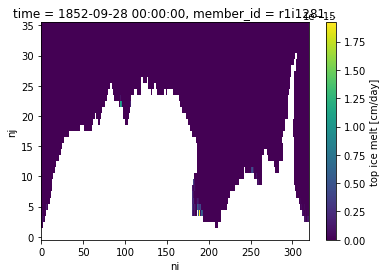

In [76]:
# check that we have all of Antarctica here
ds_subset.sel(member_id='r1i1281p1f1').isel(time=1000).plot()

In [77]:
#%%time
## actually load the data so it doesn't get too big later and makes DASK angry
#ds_subset.load()

## Section 3: Subset the times

In [78]:
ds_subset.time

<xarray.DataArray 'time' (time: 91615)>
array([cftime.DatetimeNoLeap(1850, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 1, 2, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 1, 3, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2100, 12, 29, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 30, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 31, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-01 00:00:00 ... 2100-12-31 00:00:00

In [79]:
# keep just years greater than 1980 and less than 2080 
yy_st = "1980"
yy_ed = "2080"
ds_subset = ds_subset.sel(time=slice(yy_st, yy_ed))

In [80]:
ds_subset.time.dt.month

<xarray.DataArray 'month' (time: 36865)>
array([ 1,  1,  1, ..., 12, 12, 12])
Coordinates:
  * time     (time) object 1980-01-01 00:00:00 ... 2080-12-31 00:00:00

In [81]:
# keep just times corresponding to winter (SH: all times between april and sept)
ds_subset_winter = ds_subset.isel(time=ds_subset.time.dt.month.isin([7,8,9]))

In [82]:
ds_subset_winter

,Array,Chunk
Bytes,9.97 GiB,4.04 MiB
Shape,"(25, 9292, 36, 320)","(1, 92, 36, 320)"
Count,78851 Tasks,3800 Chunks
Type,float32,numpy.ndarray


In [83]:
%%time
# actually load the data so it doesn't get too big later and makes DASK angry
#ds_subset_winter.persist()
ds_subset_winter.load()

CPU times: user 22.3 s, sys: 15.9 s, total: 38.3 s
Wall time: 1min 6s


<xarray.DataArray 'meltt_d' (member_id: 25, time: 9292, nj: 36, ni: 320)>
array([[[[          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [0.0000000e+00, 0.0000000e+00, 3.5812348e-19, ...,
                    nan,           nan,           nan],
         ...,
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

        [[          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [0.0000000e+00, 1.8528132e-18, 2.2968944e-18, ...,
                    nan,           nan,           nan],
...
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

        [[          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
                    nan,           nan,           nan],
         ...,
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00]]]], dtype=float32)
Coordinates:
    TLON       (nj, ni) float32 320.6 321.7 322.8 323.9 ... 317.2 318.3 319.4
    TLAT       (nj, ni) float32 -79.22 -79.22 -79.22 ... -60.52 -60.52 -60.52
    ULON       (nj, ni) float32 321.1 322.2 323.4 324.5 ... 317.8 318.9 320.0
    ULAT       (nj, ni) float32 -78.95 -78.95 -78.95 ... -60.25 -60.25 -60.25
  * time       (time) object 1980-07-01 00:00:00 ... 2080-09-30 00:00:00
  * member_id  (member_id) <U11 'r1i1001p1f1' 'r1i1231p1f1' ... 'r9i1301p1f1'
Dimensions without coordinates: nj, ni
Attributes:
    units:          cm/day
    long_name:      top ice melt
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

## Section 4: Save data for making composites

In [84]:
ds_subset_winter.shape

(25, 9292, 36, 320)

In [85]:
# Flatten the times and member_id
subset_for_composites = ds_subset_winter.stack(new=("member_id","time"))

In [86]:
subset_for_composites

<xarray.DataArray 'meltt_d' (nj: 36, ni: 320, new: 232300)>
array([[[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        ...,
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]],

       [[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
...
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]]], dtype=float32)
Coordinates:
    TLON       (nj, ni) float32 320.6 321.7 322.8 323.9 ... 317.2 318.3 319.4
    TLAT       (nj, ni) float32 -79.22 -79.22 -79.22 ... -60.52 -60.52 -60.52
    ULON       (nj, ni) float32 321.1 322.2 323.4 324.5 ... 317.8 318.9 320.0
    ULAT       (nj, ni) float32 -78.95 -78.95 -78.95 ... -60.25 -60.25 -60.25
  * new        (new) MultiIndex
  - member_id  (new) object 'r1i1001p1f1' 'r1i1001p1f1' ... 'r9i1301p1f1'
  - time       (new) object 1980-07-01 00:00:00 ... 2080-09-30 00:00:00
Dimensions without coordinates: nj, ni
Attributes:
    units:          cm/day
    long_name:      top ice melt
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

In [87]:
# assign to numpy array object
subsetarray = subset_for_composites.values

In [88]:
subsetarray.shape

(36, 320, 232300)

In [89]:
subset_for_composites.TLAT.values

array([[-79.22052 , -79.22052 , -79.22052 , ..., -79.22052 , -79.22052 ,
        -79.22052 ],
       [-78.68631 , -78.68631 , -78.68631 , ..., -78.68631 , -78.68631 ,
        -78.68631 ],
       [-78.15209 , -78.15209 , -78.15209 , ..., -78.15209 , -78.15209 ,
        -78.15209 ],
       ...,
       [-61.59125 , -61.59125 , -61.59125 , ..., -61.59125 , -61.59125 ,
        -61.59125 ],
       [-61.057022, -61.057022, -61.057022, ..., -61.057022, -61.057022,
        -61.057022],
       [-60.522797, -60.522797, -60.522797, ..., -60.522797, -60.522797,
        -60.522797]], dtype=float32)

## Section 5: Save data as a netcdf

In [90]:
fout = 'antarctic_data_for_som_composites_'+var_in

In [91]:
# set some info for output
longname = subset_for_composites.long_name
print(longname)
units = subset_for_composites.units
print(units)

top ice melt
cm/day


In [92]:
ds_to_save = xr.Dataset({'data': (['nj','ni','training_times'], subsetarray)},
                        coords={'time':(['training_times'],subset_for_composites.time.values),
                                'member_id':(['training_times'],subset_for_composites.member_id.values),
                                'TLON':(['nj','ni'],subset_for_composites.TLON.values),
                                'TLAT':(['nj','ni'],subset_for_composites.TLAT.values),
                                'nj':(['nj'],subset_for_composites.nj.values),
                                'ni':(['ni'],subset_for_composites.ni.values)},
                        attrs={'Author': 'Alice DuVivier', 'units':units, 'longname':longname})

In [93]:
ds_to_save

<xarray.Dataset>
Dimensions:    (nj: 36, ni: 320, training_times: 232300)
Coordinates:
    time       (training_times) object 1980-07-01 00:00:00 ... 2080-09-30 00:...
    member_id  (training_times) object 'r1i1001p1f1' ... 'r9i1301p1f1'
    TLON       (nj, ni) float32 320.6 321.7 322.8 323.9 ... 317.2 318.3 319.4
    TLAT       (nj, ni) float32 -79.22 -79.22 -79.22 ... -60.52 -60.52 -60.52
  * nj         (nj) int64 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34 35
  * ni         (ni) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
Dimensions without coordinates: training_times
Data variables:
    data       (nj, ni, training_times) float32 nan nan nan nan ... 0.0 0.0 0.0
Attributes:
    Author:    Alice DuVivier
    units:     cm/day
    longname:  top ice melt

In [94]:
ds_to_save.to_netcdf(fout+'.nc')  # how to save file